# Clock Plot Example usage
This notebook provides examples of how to use clock_plot

In [19]:
import pandas as pd
import os
import clock_plot.clock as cp
import plotly.express as px
import clock_plot
import warnings
import os
import urllib.request as urllib2
import json
from datetime import date, datetime
import plotly.io as pio

In [20]:
# Suppress warnings as there is a warning coming from plotly using pd.append rather than pd.concat
warnings.simplefilter(action='ignore', category=FutureWarning)

To get the figures to display on Github we set the renderer to 'png', but this can be set to 'notebook'/'notebook-connected' for interactive figures (or removed entirely). Note that static figures render much more quickly.

In [21]:
pio.renderers.default = 'png'

## Example data 1 - energy usage for a single house
This data is a cleaned version of energy usage for a single house from the Energy System Catapult's Living Lab - full data available [here](https://usmart.io/org/esc/discovery?tags=Living%20Lab).

In [22]:
readings_raw = pd.read_csv(os.path.join(clock_plot.CLOCK_PLOT_DIR, "..", "data", "eden_2_houseid_324_combined_data.csv"))
readings_raw["datetime"] = pd.to_datetime(readings_raw["datetime"])

As is generally the case with Plotly (the package clock_plot is built on), data needs to be in a long format rather than wide in order for grouping to work nicely.

In [23]:
readings = readings_raw.melt( id_vars=["datetime"], value_vars=["reading_elec","reading_gas"])
readings.rename(columns={"variable":"fuel","value":"reading"}, inplace=True)
readings["fuel"] = readings["fuel"].map({"reading_elec":"elec","reading_gas":"gas"})
readings.head()

,datetime,fuel,reading
0,2017-12-08 10:00:00,elec,423.688148
1,2017-12-08 11:00:00,elec,371.261564
2,2017-12-08 12:00:00,elec,448.061277
3,2017-12-08 13:00:00,elec,547.379868
4,2017-12-08 14:00:00,elec,279.790683


### Basic plot
We can start with a basic plot, showing gas usage by season. To do this, we specify the datetime and value columns, filter to fuel='gas' and specify that we want to define color based on season. Note that the colors for season are automatically defined to be relatively intuitive (though these can be overwritten).

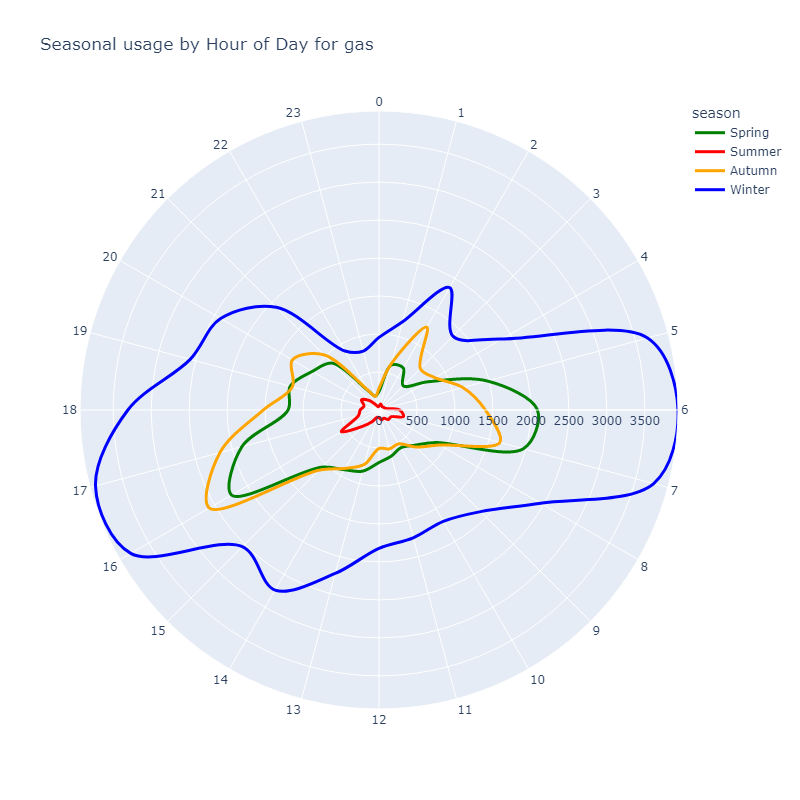

In [24]:
fig = cp.clock_plot(readings, datetime_col='datetime', value_col='reading', 
                    filters={'fuel': 'gas'}, 
                    color='season',
                    title_start='Seasonal usage')


### Advanced filtering and binning

Next, we can focus in on summer and winter months. To do this we filter based on season, using a list to specify the two seasons we are interested in, and then color based on month. We then apply a custom color sequence to make it more visually appealing.

Note that we use bins_per_day here to reduce the granularity from hourly to two-hourly, and line_shape='linear' to remove smoothing. This is more to demonstrate those capabilities than because these are the best choice here. bins_per_day is more likely to be used with a number greater than 24 (the default) if you want to plot at a more granular level (e.g. by half-hour or by minute).

We can see that in this example the definition of season works well - winter and summer months have very different usage patterns.

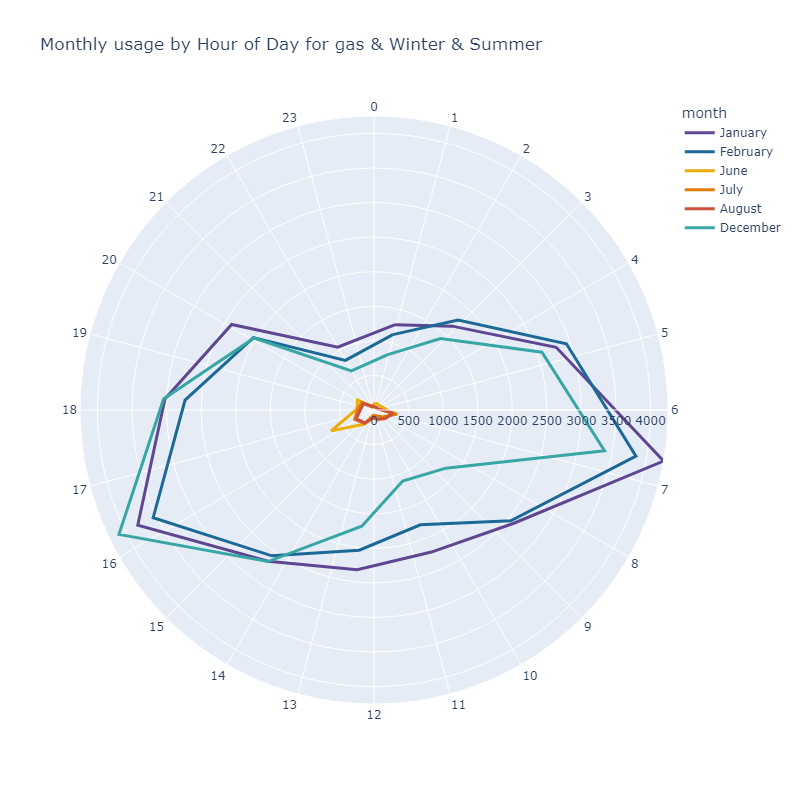

In [25]:
fig = cp.clock_plot(readings, datetime_col='datetime', value_col='reading', 
                    filters={'fuel': 'gas', 
                            'season':['Winter', 'Summer']}, 
                    color='month',
                    color_discrete_sequence=px.colors.qualitative.Prism + [px.colors.qualitative.Prism[2]],
                    title_start='Monthly usage',
                    bins_per_day=12,
                    line_shape='linear')

### Granular data and averages

The next plot shows how we can look at both granular data and averages on the same plot. For example, we can look at individual weeks within 2018 using line_group='week' and then include an average for the whole year by specifying aggregate={'year':'mean'}. Note that a subtitle is automatically generated explaining that each line represents a single week. Note that we can resize the plot by passing the standard Plotly height and width parameters in.

You can see from the plot that there's a consistent peak at either 7 or 8am, with much more varied usage in the late afternoon/evening that gets smoothed out by the average.

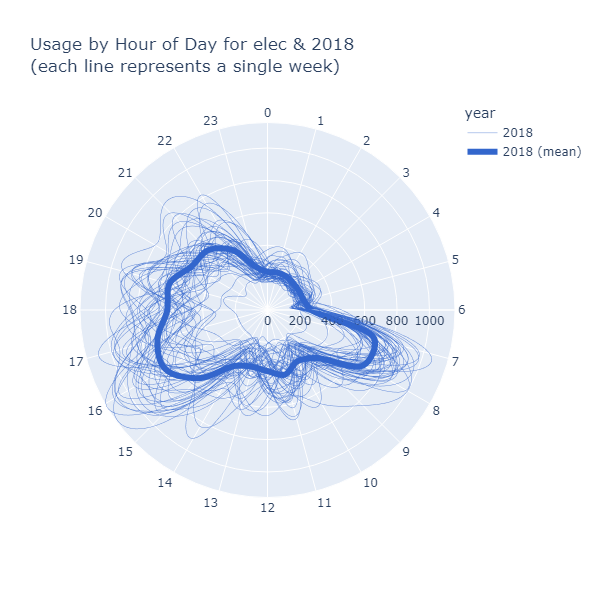

In [26]:
fig = cp.clock_plot(readings, datetime_col='datetime', value_col='reading', 
                    filters={'fuel': 'elec', 'year': 2018}, 
                    color='year',
                    line_group='week',
                    aggregate={'year':'mean'},
                    height=600,
                    width=600,                    
                    title_start='Usage')                    

### Multiple dimensions
As well as defining color, we can use line_dash so we can compare across two dimensions at once. For example, the below plot shows both gas and electricity for 2018 and 2019. It also shows a good example of the type of pattern that might be discoverable using these plots - between 2018 and 2019 the shapes have rotated one hour earlier, suggesting a change in routine for whoever is living in this house.

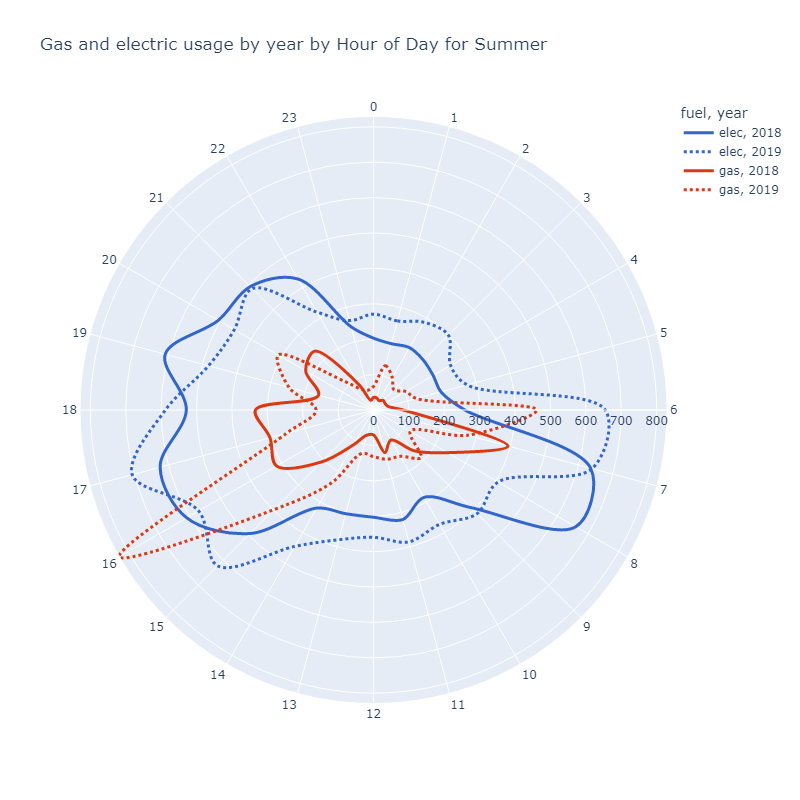

In [27]:
fig = cp.clock_plot(readings, datetime_col="datetime", value_col="reading",
                    filters={"season":"Summer"},
                    color="fuel",
                    line_dash="year",
                    title_start=f'Gas and electric usage by year')